# COCO
* The Coco format is compatible with a wide range of tools...


In [ ]:
# Based on:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=Ya5nEuMELeq8

In [ ]:
!pip3 install torch torchvision torchaudio
!pip3 install tensorboard
# If running on osx
!export ARCHFLAGS="-arch x86_64" && CC=clang CXX=clang++ pip3 install pycocotools
#!pip3 install pycocotools
!export ARCHFLAGS="-arch x86_64" && CC=clang CXX=clang++ pip3 install 'git+https://github.com/facebookresearch/detectron2.git'

In [91]:
from labelbox import Client
import os
from labelbox.data.serialization.coco.instance_dataset import CocoInstanceDataset 
from labelbox.data.serialization.coco.panoptic_dataset import CocoPanopticDataset
from labelbox.data.annotation_types import Mask
from detectron2.data.datasets import register_coco_instances,register_coco_panoptic
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from PIL import Image
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [2]:
client = Client(api_key = "", 
                endpoint = "https://staging-api.labelbox.com/graphql")


In [3]:
project_id = "ckputryh2000h0y8b65dfbo9r" #"ckq4q69ru004f0yah8sj289v2"
proj = client.get_project(project_id)
labels = proj.label_generator()

In [ ]:
# object

In [ ]:
# TODO: Make sure data exists...
im_root = "/tmp/images"
mask_root = "/tmp/masks"
if not os.path.exists(im_root):
    os.mkdir(im_root)

if not os.path.exists(mask_root):
    os.mkdir(mask_root)
    
coco = CocoInstanceDataset.from_common(
    labels = labels, 
    image_root = im_root
)

In [ ]:
coco = coco.dict() # Remove this once we refresh the notebook
n_classes = len({category['id'] for category in coco['categories']})

In [ ]:

images = coco['images']
import random
random.shuffle(images)

def get_annotations(images, all_annotations):
    image_lookup = {image['id'] for image in images}
    return [annot for annot in all_annotations if annot['image_id'] in image_lookup]


train_partition = dict(
    categories = coco['categories'],
    images = images[:int(0.8 * len(images))],
    annotations = get_annotations(images[:int(0.8 * len(images))], coco['annotations'])
)
                         
                              
test_partition = dict(
    categories = coco['categories'],
    images = images[int(0.8 * len(images)):],
    annotations = get_annotations(images[int(0.8 * len(images)):], coco['annotations']) 
)


In [ ]:
train_ds_path, test_ds_path = '/tmp/json_train_annotations.json', '/tmp/json_test_annotations.json'
with open(train_ds_path, 'w') as file:
    json.dump(train_partition, file)

with open(test_ds_path, 'w') as file:
    json.dump(test_partition, file)    


In [ ]:


register_coco_instances("custom_coco_train", {}, train_ds_path, im_root)
register_coco_instances("custom_coco_test", {}, test_ds_path, im_root)

In [ ]:
from detectron2.config import get_cfg
from detectron2.data.datasets.coco import load_coco_json
MetadataCatalog.get("custom_coco_test").thing_classes = {r['id'] : r['name'] for r in coco['categories']}
test_json = load_coco_json('/tmp/json_test_annotations.json', im_root)
images = []
import numpy as np
for idx, example in enumerate(test_json):
    if idx > 5:
        break
    
    im = cv2.imread(example['file_name'])
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("custom_coco_test"), scale=1.0)
    out = v.draw_dataset_dict(example)
    images.append(out.get_image())
Image.fromarray(np.vstack(images))

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("custom_coco_train",)

cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 20
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = n_classes 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
"""
trainer.resume_or_load(resume=False)
trainer.train()
"""

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:

evaluator = COCOEvaluator("custom_coco_test")
val_loader = build_detection_test_loader(cfg, "custom_coco_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg)

In [ ]:
images = []
import numpy as np
for idx, batch in enumerate(iter(val_loader)):
    if idx > 3:
        break
    batch_inferences = []
    for example in batch:
        im = np.transpose(example['image'].numpy(), [1,2,0])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        batch_inferences.append(out.get_image()[:, :, ::-1])
    images.append(np.hstack(batch_inferences))
Image.fromarray(np.vstack(images))

In [ ]:
MetadataCatalog.get("custom_coco_train")

In [ ]:
MetadataCatalog.get("custom_coco_train")

In [ ]:
# Panoptic

In [4]:
project_id = "ckputryh2000h0y8b65dfbo9r" #"ckq4q69ru004f0yah8sj289v2"
proj = client.get_project(project_id)
labels = proj.label_generator()

In [5]:
# TODO: Make sure data exists...
im_root = "/tmp/images"
mask_root = "/tmp/masks"
if not os.path.exists(im_root):
    os.mkdir(im_root)

if not os.path.exists(mask_root):
    os.mkdir(mask_root)
    
    
lbls = []
for idx, label in enumerate(labels):
    lbls.append(label)
    if idx > 10:
        break
        
coco = CocoPanopticDataset.from_common(
    labels = lbls, 
    image_root = im_root,
    seg_root = mask_root
)

12it [00:23,  1.96s/it]


In [50]:
coco_instance = CocoInstanceDataset.from_common(
    labels = lbls, 
    image_root = im_root
).dict()


12it [00:01,  9.52it/s]


In [51]:
coco = coco.dict() # Remove this once we refresh the notebook
n_classes = len({category['id'] for category in coco['categories']})

AttributeError: 'dict' object has no attribute 'dict'

In [54]:
images = coco['images']
import random
random.shuffle(images)

def get_annotations(images, all_annotations):
    image_lookup = {image['id'] for image in images}
    return [annot for annot in all_annotations if annot['image_id'] in image_lookup]


train_partition = dict(
    categories = coco['categories'],
    images = images[:int(0.8 * len(images))],
    annotations = get_annotations(images[:int(0.8 * len(images))], coco['annotations'])
)

train_instance_parition = dict(
    categories = coco_instance['categories'],
    images = images[:int(0.8 * len(images))],
    annotations = get_annotations(images[:int(0.8 * len(images))], coco_instance['annotations'])
)
                         

                              
test_partition = dict(
    categories = coco['categories'],
    images = images[int(0.8 * len(images)):],
    annotations = get_annotations(images[int(0.8 * len(images)):], coco['annotations']) 
)

train_ds_path, test_ds_path, train_ds_instance_path = '/tmp/json_train_annotations.json', '/tmp/json_test_annotations.json', '/tmp/instances.json'
with open(train_ds_path, 'w') as file:
    json.dump(train_partition, file)

with open(test_ds_path, 'w') as file:
    json.dump(test_partition, file)    
    
with open(train_ds_instance_path, 'w') as file:
    json.dump(train_instance_parition, file)    
    
    
    


In [55]:
{r['id'] : r['name'] for r in coco['categories']}


{0: 'car', 1: 'person'}

In [56]:
stuff_classes = ['car']
thing_classes = ['person']
stuff_dataset_id_to_contiguous_id = {0:0}
thing_dataset_id_to_contiguous_id = {0:0}
mmeta = {
    'stuff_classes' : stuff_classes,
    'thing_classes' : thing_classes,
    'stuff_dataset_id_to_contiguous_id' : stuff_dataset_id_to_contiguous_id,
    'thing_dataset_id_to_contiguous_id' : thing_dataset_id_to_contiguous_id
}

In [58]:
#mmeta = {'thing_dataset_id_to_contiguous_id' : {idx:0}}
#indices = range(len({r['id'] : r['name'] for r in coco['categories']}))
#mmeta.update({'stuff_dataset_id_to_contiguous_id' : {idx:idx for idx in indices if idx != 0}})
#mmeta.update({'thing_classes' : list({r['name'] for r in coco['categories']})})
#mmeta.update({'stuff_classes' : list({r['name'] for r in coco['categories']})})


#register_coco_panoptic("panoptic_train_6", mmeta,im_root,  mask_root,train_ds_path)
#register_coco_panoptic("panoptic_test_6", mmeta, im_root, mask_root,test_ds_path)

# We need thing and stuff classes and we need to set the mapping.



from detectron2.data.datasets import register_coco_panoptic_separated
#register_coco_panoptic_separated(name, metadata, 
#        image_root, panoptic_root, panoptic_json, sem_seg_root, instances_json).
#My_code

register_coco_panoptic_separated("panoptic_train_7", mmeta, 
        im_root, 
        mask_root, train_ds_path, 
        mask_root, train_ds_instance_path)

In [59]:
from detectron2.config import get_cfg
from detectron2.data.datasets.coco import load_coco_json
from detectron2.data.datasets.coco_panoptic import load_coco_panoptic_json
print(MetadataCatalog.get("panoptic_train_7_separated"))
test_json = load_coco_panoptic_json(test_ds_path, im_root, mask_root ,{})
images = []
import numpy as np
for idx, example in enumerate(test_json):
    if idx > 5:
        break
    
    im = cv2.imread(example['file_name'])
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("panoptic_train_7_separated"), scale=1.0)
    out = v.draw_dataset_dict(example)
    images.append(out.get_image())
Image.fromarray(np.vstack(images))


Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='/tmp/images', json_file='/tmp/instances.json', name='panoptic_train_7_separated', panoptic_json='/tmp/json_train_annotations.json', panoptic_root='/tmp/masks', sem_seg_root='/tmp/masks', stuff_classes=['car'], stuff_dataset_id_to_contiguous_id={0: 0}, thing_classes=['person'], thing_dataset_id_to_contiguous_id={0: 0})


KeyError: 'thing_dataset_id_to_contiguous_id'

In [21]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
cfg.DATASETS.TRAIN = ("panoptic_train_5_separated",)

cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = n_classes 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 


[08/02 09:47:47 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

KeyError: 'id'

In [22]:
trainer.train()

NameError: name 'trainer' is not defined

In [ ]:
!pip3 install git+https://github.com/cocodataset/panopticapi.git

In [76]:
import functools
import json
import multiprocessing as mp
import numpy as np
import os
import time
from fvcore.common.download import download
from panopticapi.utils import rgb2id
from PIL import Image




def _process_panoptic_to_semantic(input_panoptic, output_semantic, segments, id_map):
    panoptic = np.asarray(Image.open(input_panoptic), dtype=np.uint32)
    panoptic = rgb2id(panoptic)
    output = np.zeros_like(panoptic, dtype=np.uint8) + 255
    for seg in segments:
        cat_id = seg["category_id"]
        new_cat_id = id_map[cat_id]
        output[panoptic == seg["id"]] = new_cat_id
    Image.fromarray(output).save(output_semantic)


def separate_coco_semantic_from_panoptic(panoptic_json, panoptic_root, sem_seg_root, categories):
    """
    Create semantic segmentation annotations from panoptic segmentation
    annotations, to be used by PanopticFPN.
    It maps all thing categories to class 0, and maps all unlabeled pixels to class 255.
    It maps all stuff categories to contiguous ids starting from 1.
    Args:
        panoptic_json (str): path to the panoptic json file, in COCO's format.
        panoptic_root (str): a directory with panoptic annotation files, in COCO's format.
        sem_seg_root (str): a directory to output semantic annotation files
        categories (list[dict]): category metadata. Each dict needs to have:
            "id": corresponds to the "category_id" in the json annotations
            "isthing": 0 or 1
    """
    os.makedirs(sem_seg_root, exist_ok=True)

    stuff_ids = [k["id"] for k in categories] # if k["isthing"] == 0]
    thing_ids = [] #[k["id"] for k in categories if k["isthing"] == 1]
    id_map = {}  # map from category id to id in the output semantic annotation
    assert len(stuff_ids) <= 254
    for i, stuff_id in enumerate(stuff_ids):
        id_map[stuff_id] = i + 1
    for thing_id in thing_ids:
        id_map[thing_id] = 0
    id_map[0] = 255

    with open(panoptic_json) as f:
        obj = json.load(f)


    def iter_annotations():
        for anno in obj["annotations"]:
            file_name = anno["file_name"]
            segments = anno["segments_info"]
            input = os.path.join(panoptic_root, file_name)
            output = os.path.join(sem_seg_root, file_name)
            yield input, output, segments

    print("Start writing to {} ...".format(sem_seg_root))
    start = time.time()
    for i,o,s in iter_annotations():
        _process_panoptic_to_semantic(i,o,s, id_map)
    print("Finished. time: {:.2f}s".format(time.time() - start))

In [77]:
coco['categories']

[{'id': 0, 'name': 'car', 'supercategory': 'all', 'isthing': 0},
 {'id': 1, 'name': 'person', 'supercategory': 'all', 'isthing': 0}]

In [78]:
separate_coco_semantic_from_panoptic(train_ds_path, mask_root, "/tmp/segs", coco['categories'])

Start writing to /tmp/segs ...
Finished. time: 0.07s


In [ ]:
panoptic_json, panoptic_root, sem_seg_root, categories

In [79]:
!ls /"tmp/segs"

0.png  1.png  10.png 11.png 2.png  3.png  6.png  7.png  9.png


In [ ]:
register_coco_panoptic_separated("panoptic_train_5", mmeta, 
        im_root, 
        mask_root, train_ds_path, 
        mask_root, train_ds_path)

In [80]:
data_name = 'panoptic-training-11_separated'

register_coco_panoptic_separated("panoptic-training-11", {}, #mmeta, 
        im_root, 
        mask_root, train_ds_path, 
        "/tmp/segs", train_ds_instance_path)

tings = ['person', 'car']
stuffs = ['person', 'car']

In [81]:
MetadataCatalog.get("panoptic-training-11_separated").set(thing_classes=tings, stuff_classes=stuffs)

namespace(name='panoptic-training-11_separated',
          panoptic_root='/tmp/masks',
          image_root='/tmp/images',
          panoptic_json='/tmp/json_train_annotations.json',
          sem_seg_root='/tmp/segs',
          json_file='/tmp/instances.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          thing_classes=['person', 'car'],
          stuff_classes=['person', 'car'])

In [82]:
config_file = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.DATASETS.TRAIN = ("panoptic-training-11_separated",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 200
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(tings)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(stuffs)
cfg.INPUT.MASK_FORMAT = "bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/02 10:11:52 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

WARNING [08/02 10:11:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/02 10:11:52 d2.data.datasets.coco]: Loaded 9 images in COCO format from /tmp/instances.json
WARNING [08/02 10:11:52 d2.data.datasets.coco]: Directory /tmp/images and /tmp/segs has 12 and 9 files, respectively.
WARNING [08/02 10:11:52 d2.data.datasets.coco]: Will use their intersection of 9 files.
[08/02 10:11:52 d2.data.datasets.coco]: Loaded 9 images with semantic segmentation from /tmp/images
[08/02 10:11:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/02 10:11:52 d2.data.build]: Using training sampler TrainingSampler
[08/02 10:11:52 d2.data.common]: Serializing 9 elements to byte tensors and concatenating them all ...
[08/02 10:11:52 d2.data.common]: Serialized dataset takes 0.01 MiB
WARNING

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (135, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (135,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (536, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (536,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (134, 256

[08/02 10:11:53 d2.engine.train_loop]: Starting training from iteration 0
[08/02 10:17:21 d2.utils.events]:  eta: 0:48:19  iter: 19  total_loss: 10.23  loss_sem_seg: 3.863  loss_rpn_cls: 0.02125  loss_rpn_loc: 0.0309  loss_cls: 4.809  loss_box_reg: 0.894  loss_mask: 0.6914  time: 15.8438  data_time: 0.0980  lr: 2.3976e-05  
[08/02 10:22:44 d2.utils.events]:  eta: 0:43:46  iter: 39  total_loss: 8.787  loss_sem_seg: 3.168  loss_rpn_cls: 0.01923  loss_rpn_loc: 0.02761  loss_cls: 4.295  loss_box_reg: 0.9015  loss_mask: 0.6713  time: 15.9983  data_time: 0.0027  lr: 4.8951e-05  
[08/02 10:41:48 d2.utils.events]:  eta: 0:38:26  iter: 59  total_loss: 5.967  loss_sem_seg: 1.979  loss_rpn_cls: 0.02153  loss_rpn_loc: 0.01889  loss_cls: 2.617  loss_box_reg: 0.8519  loss_mask: 0.6336  time: 16.1740  data_time: 0.0024  lr: 7.3926e-05  
[08/02 10:47:16 d2.utils.events]:  eta: 0:32:51  iter: 79  total_loss: 3.925  loss_sem_seg: 1.065  loss_rpn_cls: 0.01246  loss_rpn_loc: 0.03289  loss_cls: 1.436  loss

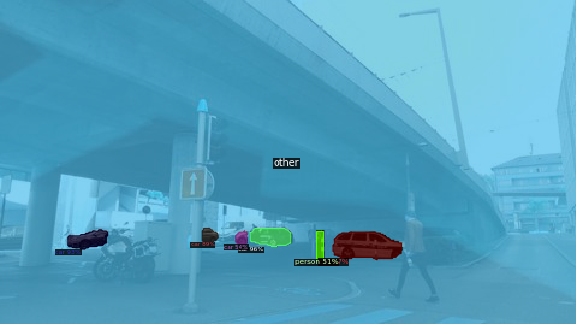

In [103]:
# Check result
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)
# for single test image
im = np.array(Image.open('/tmp/images/5.jpg'))
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get('new'), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# panoptic segmentation result
Image.fromarray(v.get_image())

In [101]:
MetadataCatalog.get('new').thing_classes = ['person', 'car', 'other']
MetadataCatalog.get('new').stuff_classes = ['person', 'car', 'other']

In [97]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='panoptic-training-11_separated',
          panoptic_root='/tmp/masks',
          image_root='/tmp/images',
          panoptic_json='/tmp/json_train_annotations.json',
          sem_seg_root='/tmp/segs',
          json_file='/tmp/instances.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          thing_classes=['person', 'car'],
          stuff_classes=['person', 'car'],
          thing_dataset_id_to_contiguous_id={31601201: 0, 82652577: 1})

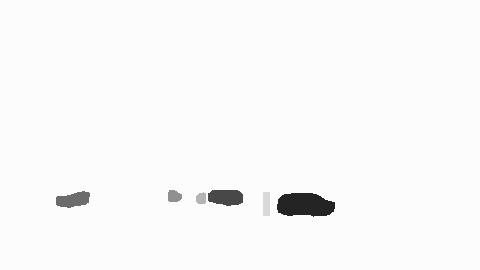

In [111]:
Image.fromarray( panoptic_seg.numpy().astype(np.uint8)* 36) 

In [113]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.9699563384056091,
  'category_id': 1,
  'instance_id': 0,
  'area': 1117.0},
 {'id': 2,
  'isthing': True,
  'score': 0.9624925851821899,
  'category_id': 1,
  'instance_id': 1,
  'area': 475.0},
 {'id': 3,
  'isthing': True,
  'score': 0.9294891357421875,
  'category_id': 1,
  'instance_id': 2,
  'area': 407.0},
 {'id': 4,
  'isthing': True,
  'score': 0.8930609226226807,
  'category_id': 1,
  'instance_id': 3,
  'area': 140.0},
 {'id': 5,
  'isthing': True,
  'score': 0.5434742569923401,
  'category_id': 1,
  'instance_id': 5,
  'area': 101.0},
 {'id': 6,
  'isthing': True,
  'score': 0.5122782588005066,
  'category_id': 0,
  'instance_id': 6,
  'area': 168.0},
 {'id': 7, 'isthing': False, 'category_id': 2, 'area': 127192.0}]